This notebook generates the processed data for all of the chapter-specific notebooks from Poldrack, Mumford, and Nichols' _Handbook of fMRI Data Analysis (2nd Edition)_

In [8]:
import os, errno, sys,shutil

datadir=os.getenv('FMRIBOOKDATA')
if not datadir:
    raise Exception('You need to set the environment variable FMRIBOOKDATA')
else:
    print 'using base dir:',datadir

assert os.path.exists(datadir)

%matplotlib inline

from nipype.interfaces import fsl, nipy, ants
import nibabel
from wand.image import Image as WImage
import numpy
import nilearn.plotting
import matplotlib.pyplot as plt
from nipype.caching import Memory
from nilearn.input_data import NiftiMasker

sys.path.append('../../utils')
from compute_fd_dvars import compute_fd,compute_dvars
from get_data import get_data
data=get_data()

# use nipype's caching mechanism to save the results of the processing
mem = Memory(base_dir='.')


figuredir='../../figures'
if not os.path.exists(figuredir):
    os.mkdir(figuredir)

boldfile=data['func']

def force_symlink(file1, file2):
    try:
        os.symlink(file1, file2)
    except OSError, e:
        if e.errno == errno.EEXIST:
            os.remove(file2)
            os.symlink(file1, file2)

using base dir: /Users/poldrack/data_unsynced/fmri-handbook-2e-data


##Structural preprocessing

###Bias field correction

In [9]:
bias_field_correction = mem.cache(ants.N4BiasFieldCorrection)
bias_field_correction_results = bias_field_correction(input_image = data['T1'], 
                                                    dimension = 3,
                                                    save_bias = True)
print bias_field_correction_results.outputs
shutil.copy(bias_field_correction_results.outputs.bias_image,datadir)
shutil.copy(bias_field_correction_results.outputs.output_image,datadir)


INFO:workflow:Executing node e4148519658a66e2b65af05cb61c352a in dir: /Users/poldrack/Dropbox/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-ants-segmentation-N4BiasFieldCorrection/e4148519658a66e2b65af05cb61c352a
INFO:workflow:Collecting precomputed outputs



bias_image = /Users/poldrack/Dropbox/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-ants-segmentation-N4BiasFieldCorrection/e4148519658a66e2b65af05cb61c352a/sub018_t1_bias.nii.gz
output_image = /Users/poldrack/Dropbox/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-ants-segmentation-N4BiasFieldCorrection/e4148519658a66e2b65af05cb61c352a/sub018_t1_corrected.nii.gz



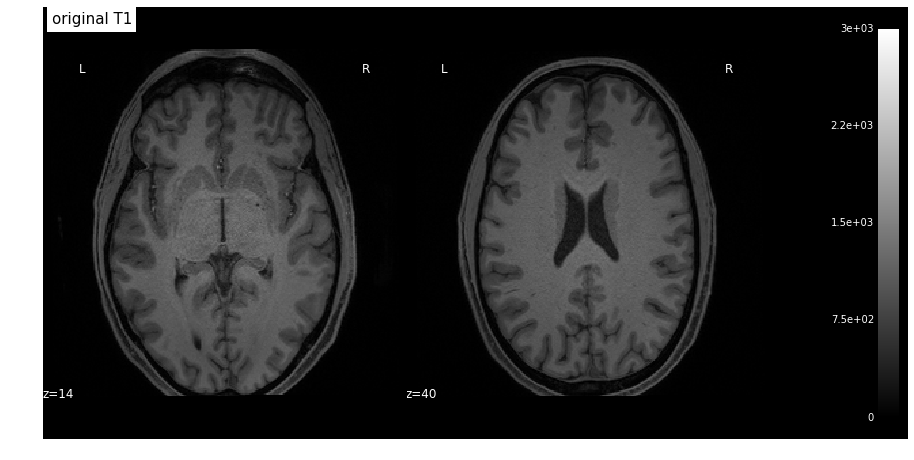

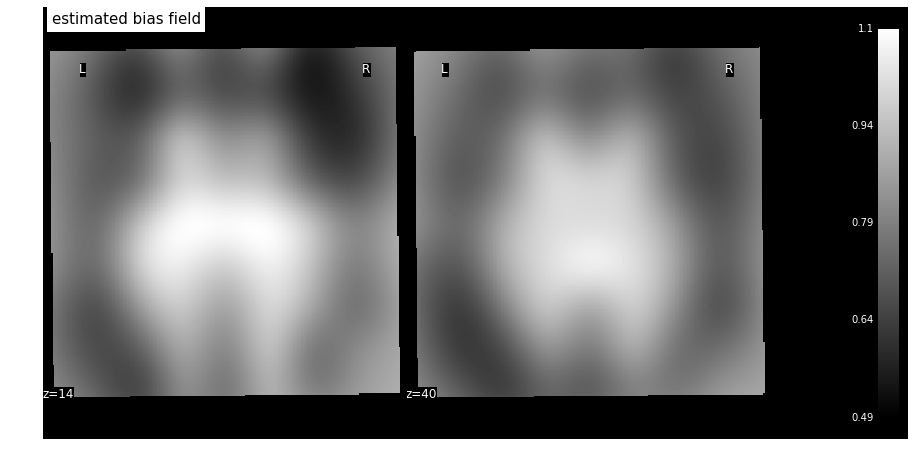

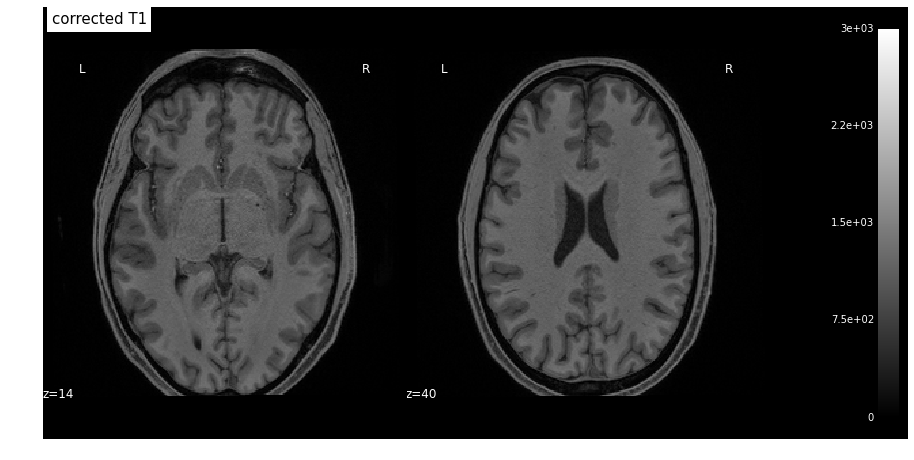

In [10]:
fig = plt.figure(figsize=(12,6))
nilearn.plotting.plot_anat(data['T1'], colorbar=True, vmax=3000, display_mode='z', cut_coords=(14, 40), 
                           title="original T1", figure=fig)
fig = plt.figure(figsize=(12,6))
nilearn.plotting.plot_anat(bias_field_correction_results.outputs.bias_image, display_mode='z', 
                          cut_coords=(14, 40), colorbar=True, title="estimated bias field", figure=fig)
fig = plt.figure(figsize=(12,6))
nilearn.plotting.plot_anat(bias_field_correction_results.outputs.output_image, colorbar=True, 
                           vmax=3000, display_mode='z', cut_coords=(14, 40), title="corrected T1", figure=fig)

###Brain extraction using BET###

INFO:workflow:Executing node 9241ae083cf61f1308aaab62e75e860b in dir: /Users/poldrack/Dropbox/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-preprocess-BET/9241ae083cf61f1308aaab62e75e860b
INFO:workflow:Collecting precomputed outputs



inskull_mask_file = <undefined>
inskull_mesh_file = <undefined>
mask_file = /Users/poldrack/Dropbox/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-preprocess-BET/9241ae083cf61f1308aaab62e75e860b/sub018_t1_corrected_brain_mask.nii.gz
meshfile = <undefined>
out_file = /Users/poldrack/Dropbox/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-preprocess-BET/9241ae083cf61f1308aaab62e75e860b/sub018_t1_corrected_brain.nii.gz
outline_file = <undefined>
outskin_mask_file = <undefined>
outskin_mesh_file = <undefined>
outskull_mask_file = <undefined>
outskull_mesh_file = <undefined>
skull_mask_file = <undefined>



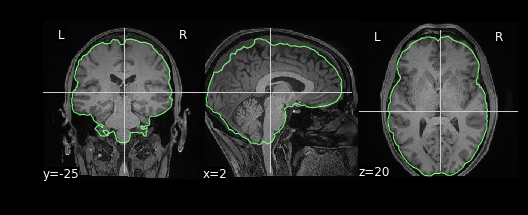

In [11]:
bet = mem.cache(fsl.BET)
bet_results = bet(in_file=bias_field_correction_results.outputs.output_image,
                  mask=True,
                  frac=0.3,
                 reduce_bias=True) # use reduce_bias option for neck cleanup

mask_display=nilearn.plotting.plot_epi(data['T1'],cmap='gray')
mask_display.add_contours(bet_results.outputs.mask_file, levels=[.5]) 
print bet_results.outputs
shutil.copy(bet_results.outputs.mask_file,datadir)
shutil.copy(bet_results.outputs.out_file,datadir)


### Segmentation using FAST

Do this to obtain the white matter mask, which we need for BBR registration.

In [12]:
fast = mem.cache(fsl.FAST)
fast_results = fast(in_files=[bet_results.outputs.out_file])
print fast_results.outputs

wmpve=nibabel.load(fast_results.outputs.partial_volume_files[2])
wmseg=wmpve.get_data()>0.25
wmsegimg=nibabel.Nifti1Image(wmseg,wmpve.get_affine(),wmpve.get_header())
wmsegimg.to_filename(os.path.join(datadir,'sub018_t1_corrected_brain_wmseg.nii.gz'))

INFO:workflow:Executing node 49e8865dd4efa1a5352f899574c19aff in dir: /Users/poldrack/Dropbox/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-preprocess-FAST/49e8865dd4efa1a5352f899574c19aff
INFO:workflow:Collecting precomputed outputs



bias_field = <undefined>
mixeltype = /Users/poldrack/Dropbox/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-preprocess-FAST/49e8865dd4efa1a5352f899574c19aff/sub018_t1_corrected_brain_mixeltype.nii.gz
partial_volume_files = ['/Users/poldrack/Dropbox/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-preprocess-FAST/49e8865dd4efa1a5352f899574c19aff/sub018_t1_corrected_brain_pve_0.nii.gz', '/Users/poldrack/Dropbox/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-preprocess-FAST/49e8865dd4efa1a5352f899574c19aff/sub018_t1_corrected_brain_pve_1.nii.gz', '/Users/poldrack/Dropbox/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-preprocess-FAST/49e8865dd4efa1a5352f899574c19aff/sub018_t1_corrected_brain_pve_2.nii.gz']
partial_volume_map = /Users/poldrack/Dropbox/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-pr

### Spatial normalization using ANTs

In [13]:
ants_reg = mem.cache(ants.Registration)
ants_results = ants_reg(fixed_image = os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'),
                    moving_image = bet_results.outputs.out_file,
                    transforms = ['Translation', 'Rigid', 'Affine', 'SyN'],
                    transform_parameters = [(0.1,), (0.1,), (0.1,), (0.2, 3.0, 0.0)],
                    #number_of_iterations = ([[10000, 111110, 11110]]*3 +
                    #                [[100, 50, 30]]),
                    number_of_iterations = ([[10, 10, 10]]*3 +
                                    [[1, 5, 3]]),
                    dimension = 3,
                    write_composite_transform = True,
                    metric = ['Mattes'] * 3 + [['Mattes', 'CC']],
                    metric_weight = [1] * 3 + [[0.5, 0.5]],
                    radius_or_number_of_bins = [32] * 3 + [[32, 4]],
                    sampling_strategy = ['Regular'] * 3 + [[None, None]],
                    sampling_percentage = [0.3] * 3 + [[None, None]],
                    convergence_threshold = [1.e-8] * 3 + [-0.01],
                    convergence_window_size = [20] * 3 + [5],
                    smoothing_sigmas = [[4, 2, 1]] * 3 + [[1, 0.5, 0]],
                    sigma_units = ['vox'] * 4,
                    shrink_factors = [[6, 4, 2]] + [[3, 2, 1]]*2 + [[4, 2, 1]],
                    use_estimate_learning_rate_once = [True] * 4,
                    use_histogram_matching = [False] * 3 + [True],
                    initial_moving_transform_com = True,
                    output_warped_image = True)
shutil.copy(ants_results.outputs.composite_transform, os.path.join(datadir, "t1_to_mni_warp.h5"))
shutil.copy(ants_results.outputs.warped_image,os.path.join(datadir,'t1_to_mni_warp.nii.gz'))
ants_results.outputs

/Users/poldrack/anaconda/lib/python2.7/site-packages/nipype/interfaces/base.py:412: UserWarning: Input sigma_units requires inputs: smoothing_sigmas
  warn(msg)
/Users/poldrack/anaconda/lib/python2.7/site-packages/nipype/interfaces/base.py:412: UserWarning: Input sampling_percentage requires inputs: sampling_strategy
  warn(msg)
/Users/poldrack/anaconda/lib/python2.7/site-packages/nipype/interfaces/base.py:412: UserWarning: Input convergence_threshold requires inputs: number_of_iterations
  warn(msg)
/Users/poldrack/anaconda/lib/python2.7/site-packages/nipype/interfaces/base.py:412: UserWarning: Input metric_weight requires inputs: metric
  warn(msg)
INFO:workflow:Executing node 8620796f4a467080846d9d0758bfc00f in dir: /Users/poldrack/Dropbox/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-ants-registration-Registration/8620796f4a467080846d9d0758bfc00f
INFO:workflow:Collecting precomputed outputs



composite_transform = /Users/poldrack/Dropbox/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-ants-registration-Registration/8620796f4a467080846d9d0758bfc00f/transformComposite.h5
forward_invert_flags = []
forward_transforms = []
inverse_composite_transform = /Users/poldrack/Dropbox/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-ants-registration-Registration/8620796f4a467080846d9d0758bfc00f/transformInverseComposite.h5
inverse_warped_image = <undefined>
reverse_invert_flags = []
reverse_transforms = []
save_state = <undefined>
warped_image = /Users/poldrack/Dropbox/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-ants-registration-Registration/8620796f4a467080846d9d0758bfc00f/transform_Warped.nii.gz

### Register T2 to T1
    

In [14]:
flirt=mem.cache(fsl.FLIRT)
flirt_results=flirt(in_file=data['T2'],reference=os.path.join(datadir,'sub018_t1_corrected.nii.gz'),
                    out_file=os.path.join(datadir,'t2_reg2t1.nii.gz'),
                    cost='normmi',interp='spline')
flirt_results.outputs

INFO:workflow:Executing node 9ca3e6813f6e9759b25d305d8d887de0 in dir: /Users/poldrack/Dropbox/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-preprocess-FLIRT/9ca3e6813f6e9759b25d305d8d887de0
INFO:workflow:Running: flirt -in /Users/poldrack/data_unsynced/fmri-handbook-2e-data/sub018_t2.nii.gz -ref /Users/poldrack/data_unsynced/fmri-handbook-2e-data/sub018_t1_corrected.nii.gz -out /Users/poldrack/data_unsynced/fmri-handbook-2e-data/t2_reg2t1.nii.gz -omat sub018_t2_flirt.mat -cost normmi -interp spline



out_file = /Users/poldrack/data_unsynced/fmri-handbook-2e-data/t2_reg2t1.nii.gz
out_log = /Users/poldrack/Dropbox/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-preprocess-FLIRT/9ca3e6813f6e9759b25d305d8d887de0/sub018_t2_flirt.log
out_matrix_file = /Users/poldrack/Dropbox/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-preprocess-FLIRT/9ca3e6813f6e9759b25d305d8d887de0/sub018_t2_flirt.mat

## Functional preprocessing

### Motion correction using MCFLIRT

This will take a few minutes.

In [33]:
mcflirt = mem.cache(fsl.MCFLIRT)
mcflirt_results = mcflirt(in_file=boldfile,
                          save_plots=True,
                          mean_vol=True)
print mcflirt_results.outputs

shutil.copy(mcflirt_results.outputs.mean_img, os.path.join(datadir, "meanbold.nii.gz"))
shutil.copy(mcflirt_results.outputs.par_file, os.path.join(datadir, "motion.par"))
shutil.copy(mcflirt_results.outputs.out_file, os.path.join(datadir, boldfile.replace('.nii.gz','_mcf.nii.gz')))

INFO:workflow:Executing node dde72ae7522d5cc382950ffbf90afca5 in dir: /Users/poldrack/Dropbox/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-preprocess-MCFLIRT/dde72ae7522d5cc382950ffbf90afca5
INFO:workflow:Collecting precomputed outputs



mat_file = <undefined>
mean_img = /Users/poldrack/Dropbox/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-preprocess-MCFLIRT/dde72ae7522d5cc382950ffbf90afca5/sub00001_ses014_task002_run001_bold_mcf.nii.gz_mean_reg.nii.gz
out_file = /Users/poldrack/Dropbox/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-preprocess-MCFLIRT/dde72ae7522d5cc382950ffbf90afca5/sub00001_ses014_task002_run001_bold_mcf.nii.gz
par_file = /Users/poldrack/Dropbox/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-preprocess-MCFLIRT/dde72ae7522d5cc382950ffbf90afca5/sub00001_ses014_task002_run001_bold_mcf.nii.gz.par
rms_files = <undefined>
std_img = <undefined>
variance_img = <undefined>



Make links for the mean functional image and the motion parameters.

##Brain extraction##

Use FSL's BET to obtain the brain mask for the functional data

In [16]:
bet = mem.cache(fsl.BET)
bet_results = bet(functional=True,
              in_file=mcflirt_results.outputs.mean_img,
              mask=True)
shutil.copy(bet_results.outputs.mask_file, os.path.join(datadir, "bold_mask.nii.gz"))
bet_results.outputs

INFO:workflow:Executing node 6199c9a81b9528b0a2599c09795000f5 in dir: /Users/poldrack/Dropbox/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-preprocess-BET/6199c9a81b9528b0a2599c09795000f5
INFO:workflow:Collecting precomputed outputs



inskull_mask_file = <undefined>
inskull_mesh_file = <undefined>
mask_file = /Users/poldrack/Dropbox/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-preprocess-BET/6199c9a81b9528b0a2599c09795000f5/sub00001_ses014_task002_run001_bold_mcf.nii.gz_mean_reg_brain_mask.nii.gz
meshfile = <undefined>
out_file = /Users/poldrack/Dropbox/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-preprocess-BET/6199c9a81b9528b0a2599c09795000f5/sub00001_ses014_task002_run001_bold_mcf.nii.gz_mean_reg_brain.nii.gz
outline_file = <undefined>
outskin_mask_file = <undefined>
outskin_mesh_file = <undefined>
outskull_mask_file = <undefined>
outskull_mesh_file = <undefined>
skull_mask_file = <undefined>

Display the mean image, and show the outline of the brain mask.

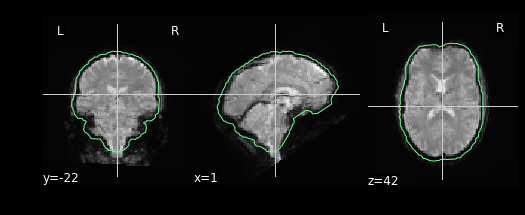

In [17]:
mask_display=nilearn.plotting.plot_epi(mcflirt_results.outputs.mean_img,cmap='gray')
mask_display.add_contours(bet_results.outputs.mask_file, levels=[.5])

Compute and plot the global signal within the mask across timepoints

In [18]:
niftimasker=NiftiMasker(mask_img=bet_results.outputs.mask_file)
bolddata_masked=niftimasker.fit_transform(mcflirt_results.outputs.out_file)
globalmean=numpy.mean(bolddata_masked,1)

### QA for fMRI data

Load motion data and compute FD/DVARS

In [19]:
motiondata=numpy.loadtxt(mcflirt_results.outputs.par_file)
fd=compute_fd(motiondata)
dvars=compute_dvars(globalmean)
numpy.savetxt(os.path.join(datadir,'FD.txt'),fd)
numpy.savetxt(os.path.join(datadir,'DVARS.txt'),dvars)

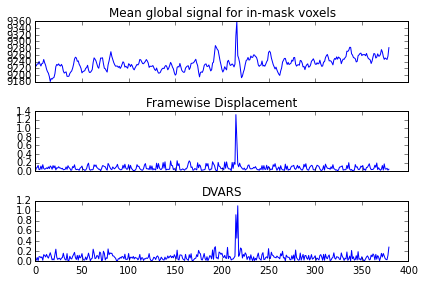

In [20]:
f, (ax1, ax2,ax3)=plt.subplots(3, sharex=True)
ax1.plot(globalmean)
ax1.set_title('Mean global signal for in-mask voxels')

ax2.plot(fd)
ax2.set_title('Framewise Displacement')

ax3.plot(dvars)
ax3.set_title('DVARS')
plt.tight_layout()

## Performing Independent Component Analysis to look for artefacts

Run independent components analysis on the data using MELODIC - this will take a few minutes.

In [21]:
if not os.path.exists(os.path.join(datadir,'sub00001_ses014_task002_run001_bold.ica')):
    melodic = mem.cache(fsl.MELODIC)
    melodic_results = melodic(out_all=True,
                              report=True,
                              in_files=mcflirt_results.outputs.out_file,
                              mask=bet_results.outputs.mask_file)
    melodic_results.outputs
    shutil.copytree(melodic_results.outputs.out_dir,os.path.join(datadir,'sub00001_ses014_task002_run001_bold.ica'))


INFO:workflow:Executing node 8459f1ca464e50afaa7dc6ac80f28d66 in dir: /Users/poldrack/Dropbox/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-model-MELODIC/8459f1ca464e50afaa7dc6ac80f28d66
INFO:workflow:Collecting precomputed outputs


OSError: [Errno 17] File exists: '/Users/poldrack/data_unsynced/fmri-handbook-2e-data/sub00001_ses014_task002_run001_bold.ica'

Check out the MELODIC report

In [22]:
from IPython.display import FileLink
FileLink(os.path.join(melodic_results.outputs.report_dir, '00index.html').split(os.getcwd() + '/')[1])

/Users/poldrack/Dropbox/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-model-MELODIC/8459f1ca464e50afaa7dc6ac80f28d66/report/00index.html

Load the ICA components and examine their correlation with the motion signals. For components with a correlation > 0.4, show the component voxels.

In [23]:
ica_comps=numpy.loadtxt(os.path.join(melodic_results.outputs.out_dir,'melodic_mix'))
os.listdir(melodic_results.outputs.out_dir)

['_0x80dd382666428029ef8b59ac560845e0.json',
 '_inputs.pklz',
 '_node.pklz',
 '_report',
 'command.txt',
 'eigenvalues_percent',
 'log.txt',
 'mask.nii.gz',
 'mean.nii.gz',
 'melodic_dewhite',
 'melodic_FTdewhite',
 'melodic_FTmix',
 'melodic_IC.nii.gz',
 'melodic_ICstats',
 'melodic_mix',
 'melodic_oIC.nii.gz',
 'melodic_pca.nii.gz',
 'melodic_pcaD',
 'melodic_pcaE',
 'melodic_PPCA',
 'melodic_Tmodes',
 'melodic_unmix',
 'melodic_white',
 'Noise__inv.nii.gz',
 'report',
 'result_8459f1ca464e50afaa7dc6ac80f28d66.pklz',
 'stats']

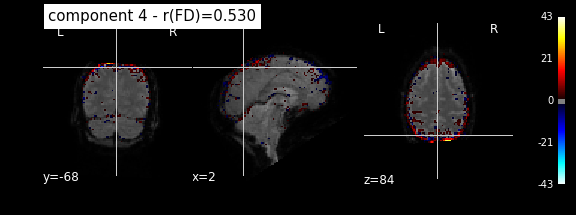

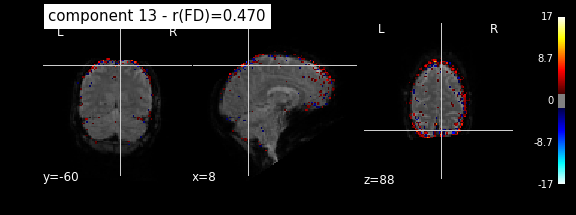

In [24]:
ica_motion_corr=numpy.zeros(ica_comps.shape[1])
for c in range(ica_comps.shape[1]):
    ica_motion_corr[c]=numpy.corrcoef(ica_comps[:,c],fd)[0,1]
    if abs(ica_motion_corr[c])>0.4:
        comp_img=nibabel.load(os.path.join(melodic_results.outputs.out_dir,'stats/thresh_zstat%d.nii.gz'%int(c+1)))
        nilearn.plotting.plot_stat_map(comp_img,mcflirt_results.outputs.mean_img,threshold=1.5,
               title='component %d - r(FD)=%0.3f'%(c+1,ica_motion_corr[c]))
        


## Fieldmap unwarping

Take the first magnitue image and skull strip it

INFO:workflow:Executing node a4567e41c0303fa12fb544aafb076655 in dir: /Users/poldrack/Dropbox/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/a4567e41c0303fa12fb544aafb076655
INFO:workflow:Collecting precomputed outputs
INFO:workflow:Executing node 39e53ae7e626e4c2a5dd3e10bc6c3594 in dir: /Users/poldrack/Dropbox/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-preprocess-BET/39e53ae7e626e4c2a5dd3e10bc6c3594
INFO:workflow:Collecting precomputed outputs


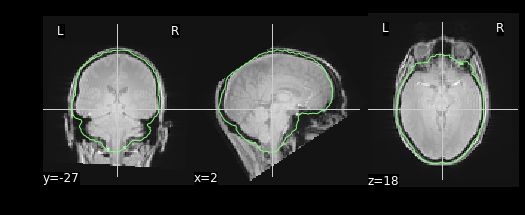

In [25]:
magfile=os.path.join(datadir,'sub00001_ses014_001_magnitude.nii.gz')
roi = mem.cache(fsl.ExtractROI)
pick_first_mag = roi(in_file=magfile, t_min=0, t_size=1)

# we'll need this later
shutil.copy(pick_first_mag.outputs.roi_file, os.path.join(datadir, "fmapmag.nii.gz"))

mag_bet_results = bet(functional=True,
                      in_file=pick_first_mag.outputs.roi_file,
                      mask=True,
                      frac=0.65)
mag_bet_results.outputs
mask_display=nilearn.plotting.plot_epi(pick_first_mag.outputs.roi_file,cmap='gray')
mask_display.add_contours(mag_bet_results.outputs.mask_file, levels=[.5])
shutil.copy(mag_bet_results.outputs.out_file, os.path.join(datadir, "fmapmagbrain.nii.gz"))


Prepare the fieldmap

In [26]:
prepare = mem.cache(fsl.PrepareFieldmap)
prepare_results = prepare(in_phase = os.path.join(datadir,'sub00001_ses014_001_phasediff.nii.gz'),
                          in_magnitude = mag_bet_results.outputs.out_file,
                          output_type = "NIFTI_GZ")
shutil.copy(prepare_results.outputs.out_fieldmap, os.path.join(datadir, "fieldmap.nii.gz"))
prepare_results.outputs

INFO:workflow:Executing node 2267d82aff0782b65cf1f7b9afd9fe97 in dir: /Users/poldrack/Dropbox/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-epi-PrepareFieldmap/2267d82aff0782b65cf1f7b9afd9fe97
INFO:workflow:Collecting precomputed outputs



out_fieldmap = /Users/poldrack/Dropbox/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-epi-PrepareFieldmap/2267d82aff0782b65cf1f7b9afd9fe97/sub00001_ses014_001_phasediff_fslprepared.nii.gz

Which parts of the brain were most deformed by B0 inhomogeneities?

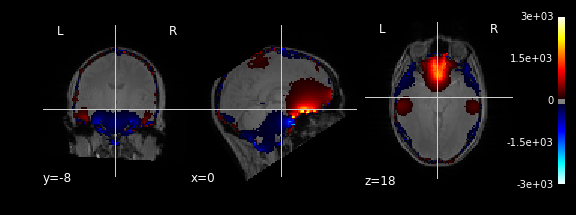

In [27]:
nilearn.plotting.plot_stat_map(nilearn.image.index_img(prepare_results.outputs.out_fieldmap,0), 
                               pick_first_mag.outputs.roi_file, threshold=100)

Note that we don't really apply these transformations yet. We'll do it after first level modelling

In [28]:
fugue = mem.cache(fsl.FUGUE)
fugue_results = fugue(in_file = mcflirt_results.outputs.mean_img,
                      fmap_in_file = prepare_results.outputs.out_fieldmap,
                      unwarp_direction = "y",
                      dwell_time = 2.6/10000.0,
                      mask_file = mag_bet_results.outputs.mask_file)
fugue_results.outputs
shutil.copy(fugue_results.outputs.unwarped_file,os.path.join(datadir,'meanfunc_unwarped.nii.gz'))

INFO:workflow:Executing node ff03fbc0a8bad4dfce1094a479425bae in dir: /Users/poldrack/Dropbox/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-preprocess-FUGUE/ff03fbc0a8bad4dfce1094a479425bae
INFO:workflow:Running: fugue --dwell=0.0002600000 --loadfmap=/Users/poldrack/Dropbox/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-epi-PrepareFieldmap/2267d82aff0782b65cf1f7b9afd9fe97/sub00001_ses014_001_phasediff_fslprepared.nii.gz --in=/Users/poldrack/Dropbox/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-preprocess-MCFLIRT/dde72ae7522d5cc382950ffbf90afca5/sub00001_ses014_task002_run001_bold_mcf.nii.gz_mean_reg.nii.gz --mask=/Users/poldrack/Dropbox/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-preprocess-BET/39e53ae7e626e4c2a5dd3e10bc6c3594/sub00001_ses014_001_magnitude_roi_brain_mask.nii.gz --unwarpdir=y --unwarp=sub00001_ses014_task002_run

## Combined corregistration and fieldmap unwarping using boundary based registration

In [32]:
epi_reg = mem.cache(fsl.EpiReg)
epi_reg_results = epi_reg(epi=mcflirt_results.outputs.mean_img,
                          t1_head=bias_field_correction_results.outputs.output_image,
                          t1_brain=os.path.join(datadir,'sub018_t1_corrected_brain.nii.gz'),
                          fmap=prepare_results.outputs.out_fieldmap,
                          fmapmag=pick_first_mag.outputs.roi_file,
                          fmapmagbrain=mag_bet_results.outputs.out_file,
                          echospacing=2.6/10000.0,
                          pedir='y',
                          out_base="epi2struct")

shutil.copy(epi_reg_results.outputs.out_file, os.path.join(datadir, "epi_bbreg_to_t1.nii.gz"))
shutil.copy(epi_reg_results.outputs.epi2str_mat , os.path.join(datadir, "epi2struct.mat"))
shutil.copy(epi_reg_results.outputs.epi2str_inv , os.path.join(datadir, "epi2struct_inv.mat"))
epi_reg_results.outputs

flirt=mem.cache(fsl.FLIRT)
flirt_results=flirt(in_file=fugue_results.outputs.unwarped_file,
                    out_file=os.path.join(datadir, "epi_unwarped_bbreg_to_t1.nii.gz"),
                    apply_xfm=True,in_matrix_file=epi_reg_results.outputs.epi2str_mat,
                    reference=fugue_results.outputs.unwarped_file)
    

INFO:workflow:Executing node ce8c0299d8dd0522051c7449753b5149 in dir: /Users/poldrack/Dropbox/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/ce8c0299d8dd0522051c7449753b5149
INFO:workflow:Collecting precomputed outputs
INFO:workflow:Executing node dd00f46bd33c51297bc812b1c0bd561e in dir: /Users/poldrack/Dropbox/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-preprocess-FLIRT/dd00f46bd33c51297bc812b1c0bd561e
INFO:workflow:Running: flirt -in /Users/poldrack/Dropbox/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-preprocess-FUGUE/ff03fbc0a8bad4dfce1094a479425bae/sub00001_ses014_task002_run001_bold_mcf.nii.gz_mean_reg_unwarped.nii.gz -ref /Users/poldrack/Dropbox/code/fmri-handbook-2e-code/notebooks/DataPreparation/nipype_mem/nipype-interfaces-fsl-preprocess-FUGUE/ff03fbc0a8bad4dfce1094a479425bae/sub00001_ses014_task002_run001_bold_mcf.nii.gz_mean_reg_unwarped.nii.gz

In [ ]:
T1_to_MNI_warp = mem.cache(ants.ApplyTransforms)
T1wm_to_MNI_warp_results = T1_to_MNI_warp(input_image = epi_reg_results.outputs.wmseg,
                                          reference_image = os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'),
                                          interpolation = "NearestNeighbor",
                                          transforms = ants_results.outputs.composite_transform)

fig = nilearn.plotting.plot_anat(os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'))
fig.add_contours(T1wm_to_MNI_warp_results.outputs.output_image, levels=[.5]) 

## Spatial smoothing

Perform spatial smoothing using Gaussian kernel. Can you spot the difference between top and bottom rows?

INFO:workflow:Executing node 61b7f927f50f1e2f1187e23ed0c9eb38 in dir: /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-utils-Smooth/61b7f927f50f1e2f1187e23ed0c9eb38
INFO:workflow:Collecting precomputed outputs


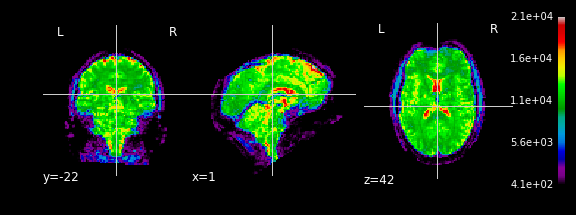

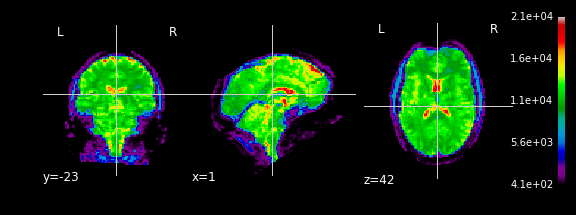

In [20]:
smooth = mem.cache(fsl.utils.Smooth)
smooth_results = smooth(fwhm=2.5,
                        in_file=mcflirt_results.outputs.out_file,
                        output_type = "NIFTI")

nilearn.plotting.plot_epi(mcflirt_results.outputs.mean_img,colorbar=True, vmin=410, vmax=21000)
nilearn.plotting.plot_epi(nilearn.image.mean_img(smooth_results.outputs.smoothed_file), colorbar=True, vmin=410, vmax=21000)

## High pass filtering

High-pass filtering - this will take a few minutes

In [21]:
hpfilt = mem.cache(fsl.maths.TemporalFilter)
TR = 2.32
hpfilt_results = hpfilt(highpass_sigma = 100/(2*TR),
                        in_file=smooth_results.outputs.smoothed_file,
                        output_type = "NIFTI")

mean = mem.cache(fsl.maths.MeanImage)
mean_results = mean(in_file = smooth_results.outputs.smoothed_file)

rescale = mem.cache(fsl.maths.BinaryMaths)
rescale_results = rescale(in_file=hpfilt_results.outputs.out_file,
                          operand_file = mean_results.outputs.out_file,
                          operation = "add",
                          output_type = "NIFTI")

force_symlink(rescale_results.outputs.out_file, os.path.join(results_dir, "preprocessed_epi_native_space.nii"))

INFO:workflow:Executing node f7ad533e4a31e1d4df6eae69ac95a245 in dir: /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-maths-TemporalFilter/f7ad533e4a31e1d4df6eae69ac95a245
INFO:workflow:Collecting precomputed outputs
INFO:workflow:Executing node 73ff20dc51f2a3c5afc6b62dcc6b026c in dir: /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-maths-MeanImage/73ff20dc51f2a3c5afc6b62dcc6b026c
INFO:workflow:Collecting precomputed outputs
INFO:workflow:Executing node 8f2127a6d1564a45e01faaca63593d82 in dir: /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-maths-BinaryMaths/8f2127a6d1564a45e01faaca63593d82
INFO:workflow:Collecting precomputed outputs
